In [1]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import torch.nn.functional as F


Mounted at /content/drive


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
import kagglehub
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Download dataset
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Dataset Path:", path)

# The actual images are inside 'flowers'
data_dir = os.path.join(path, "flowers")
print("Data Directory:", data_dir)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

# Load full dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into Train (80%) and Validation (20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

flower_train, flower_val = random_split(full_dataset, [train_size, val_size])

# DataLoaders
flower_train_loader = DataLoader(flower_train, batch_size=32, shuffle=True)
flower_val_loader = DataLoader(flower_val, batch_size=32, shuffle=False)

num_classes = len(full_dataset.classes)

print("Classes:", full_dataset.classes)
print("Number of classes:", num_classes)
print("Train size:", len(flower_train))
print("Validation size:", len(flower_val))


Using Colab cache for faster access to the 'flowers-recognition' dataset.
Dataset Path: /kaggle/input/flowers-recognition
Data Directory: /kaggle/input/flowers-recognition/flowers
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Number of classes: 5
Train size: 3453
Validation size: 864


In [6]:
# Make sure drive is mounted first
from google.colab import drive
drive.mount('/content/drive')

# Recreate EfficientNet architecture
from torchvision import models
import torch.nn as nn

def get_efficientnet(num_classes):
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(
        model.classifier[1].in_features,
        num_classes
    )
    return model

# Create model
model_base = get_efficientnet(num_classes)

# Load saved weights
model_base.load_state_dict(
    torch.load("/content/drive/MyDrive/cnn_models/efficientnet_flower.pth",
               map_location=device)
)

model_base = model_base.to(device)
model_base.eval()

print("EfficientNet model loaded successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet model loaded successfully.


In [8]:
import numpy as np
import torch

# Get class counts from training subset
train_labels = [full_dataset.samples[i][1] for i in flower_train.indices]
class_counts = np.bincount(train_labels)

print("Class Counts:", class_counts)

# Minority class
minority_class = np.argmin(class_counts)
print("Minority Class Index:", minority_class)

# Weights for Weighted CE
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)
class_weights = class_weights.to(device)


Class Counts: [615 841 621 595 781]
Minority Class Index: 3


In [9]:
import torch.nn.functional as F
import torch.nn as nn

# 1. Cross Entropy
ce_loss = nn.CrossEntropyLoss()

# 2. Weighted Cross Entropy
weighted_ce = nn.CrossEntropyLoss(weight=class_weights)

# 3. Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

# 4. Class Balanced Loss
class ClassBalancedLoss(nn.Module):
    def __init__(self, samples_per_cls, beta=0.9999):
        super().__init__()
        effective_num = 1.0 - np.power(beta, samples_per_cls)
        weights = (1.0 - beta) / effective_num
        weights = weights / np.sum(weights) * len(samples_per_cls)
        self.weights = torch.tensor(weights, dtype=torch.float).to(device)

    def forward(self, inputs, targets):
        return F.cross_entropy(inputs, targets, weight=self.weights)

cb_loss = ClassBalancedLoss(class_counts)

# 5. Label Smoothing
label_smooth = nn.CrossEntropyLoss(label_smoothing=0.1)


In [10]:
import torch.optim as optim

def get_optimizer(name, model):
    if name == "SGD":
        return optim.SGD(model.parameters(), lr=0.01)
    elif name == "SGD_Momentum":
        return optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    elif name == "Adam":
        return optim.Adam(model.parameters(), lr=0.001)
    elif name == "AdamW":
        return optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    elif name == "RMSProp":
        return optim.RMSprop(model.parameters(), lr=0.001)


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=5):

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_running_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        if scheduler:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f}")

    return train_losses, val_losses


In [12]:
loss_dict = {
    "CE": ce_loss,
    "WeightedCE": weighted_ce,
    "Focal_g0.5": FocalLoss(gamma=0.5),
    "Focal_g1": FocalLoss(gamma=1),
    "Focal_g2": FocalLoss(gamma=2),
    "Focal_g5": FocalLoss(gamma=5),
    "ClassBalanced": cb_loss,
    "LabelSmoothing": label_smooth
}

optimizer_list = ["SGD", "SGD_Momentum", "Adam", "AdamW", "RMSProp"]

results = {}

for loss_name, criterion in loss_dict.items():
    for opt_name in optimizer_list:

        print("\nRunning:", loss_name, "+", opt_name)

        model = get_efficientnet(num_classes).to(device)
        optimizer = get_optimizer(opt_name, model)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

        train_loss, val_loss = train_model(
            model,
            flower_train_loader,
            flower_val_loader,
            criterion,
            optimizer,
            scheduler=scheduler,
            epochs=5
        )

        results[f"{loss_name}_{opt_name}"] = {
            "train": train_loss,
            "val": val_loss,
            "model": model
        }



Running: CE + SGD
Epoch [1/5] Train Loss: 1.4836 | Val Loss: 1.5329
Epoch [2/5] Train Loss: 1.1985 | Val Loss: 1.4678
Epoch [3/5] Train Loss: 1.0999 | Val Loss: 1.4016
Epoch [4/5] Train Loss: 0.9611 | Val Loss: 1.0790
Epoch [5/5] Train Loss: 0.9074 | Val Loss: 0.9235

Running: CE + SGD_Momentum
Epoch [1/5] Train Loss: 1.4746 | Val Loss: 3.5261
Epoch [2/5] Train Loss: 1.2839 | Val Loss: 1.5384
Epoch [3/5] Train Loss: 1.0611 | Val Loss: 0.9901
Epoch [4/5] Train Loss: 0.9094 | Val Loss: 0.9573
Epoch [5/5] Train Loss: 0.8433 | Val Loss: 0.9729

Running: CE + Adam
Epoch [1/5] Train Loss: 1.4453 | Val Loss: 1.5361
Epoch [2/5] Train Loss: 1.1070 | Val Loss: 0.9792
Epoch [3/5] Train Loss: 0.9638 | Val Loss: 0.8847
Epoch [4/5] Train Loss: 0.8467 | Val Loss: 0.7795
Epoch [5/5] Train Loss: 0.7517 | Val Loss: 0.7929

Running: CE + AdamW
Epoch [1/5] Train Loss: 1.3971 | Val Loss: 1.4046
Epoch [2/5] Train Loss: 1.0914 | Val Loss: 1.1853
Epoch [3/5] Train Loss: 0.9453 | Val Loss: 1.0874
Epoch [4/5] 

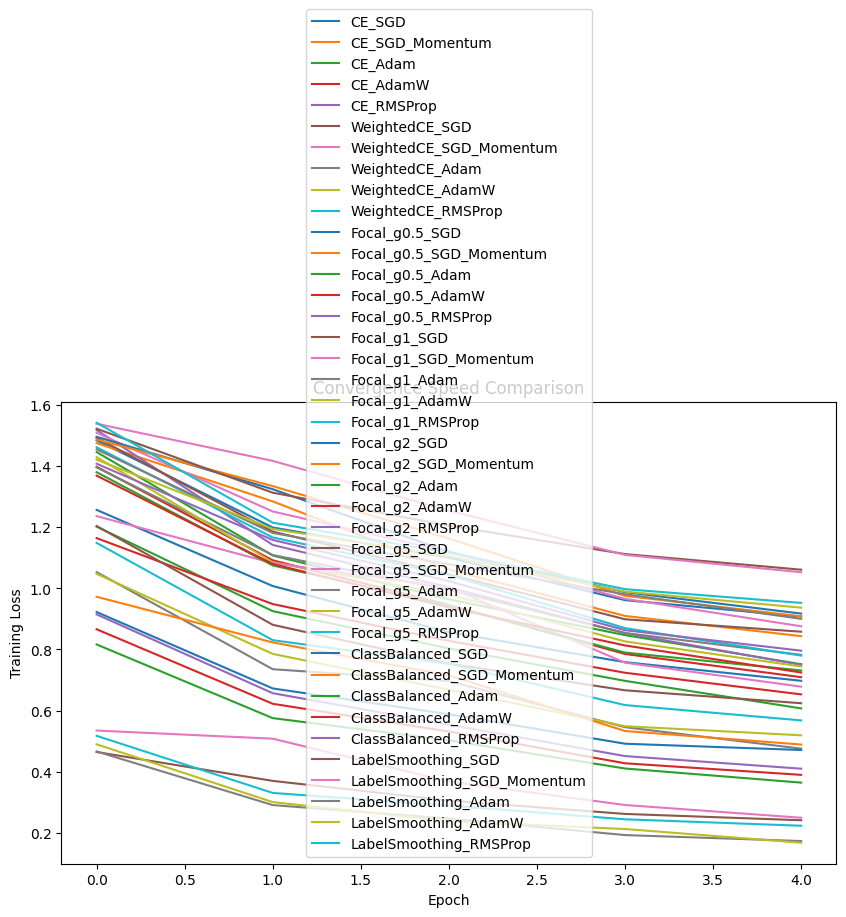

In [13]:
plt.figure(figsize=(10,6))

for name in results:
    plt.plot(results[name]["train"], label=name)

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Convergence Speed Comparison")
plt.legend()
plt.show()


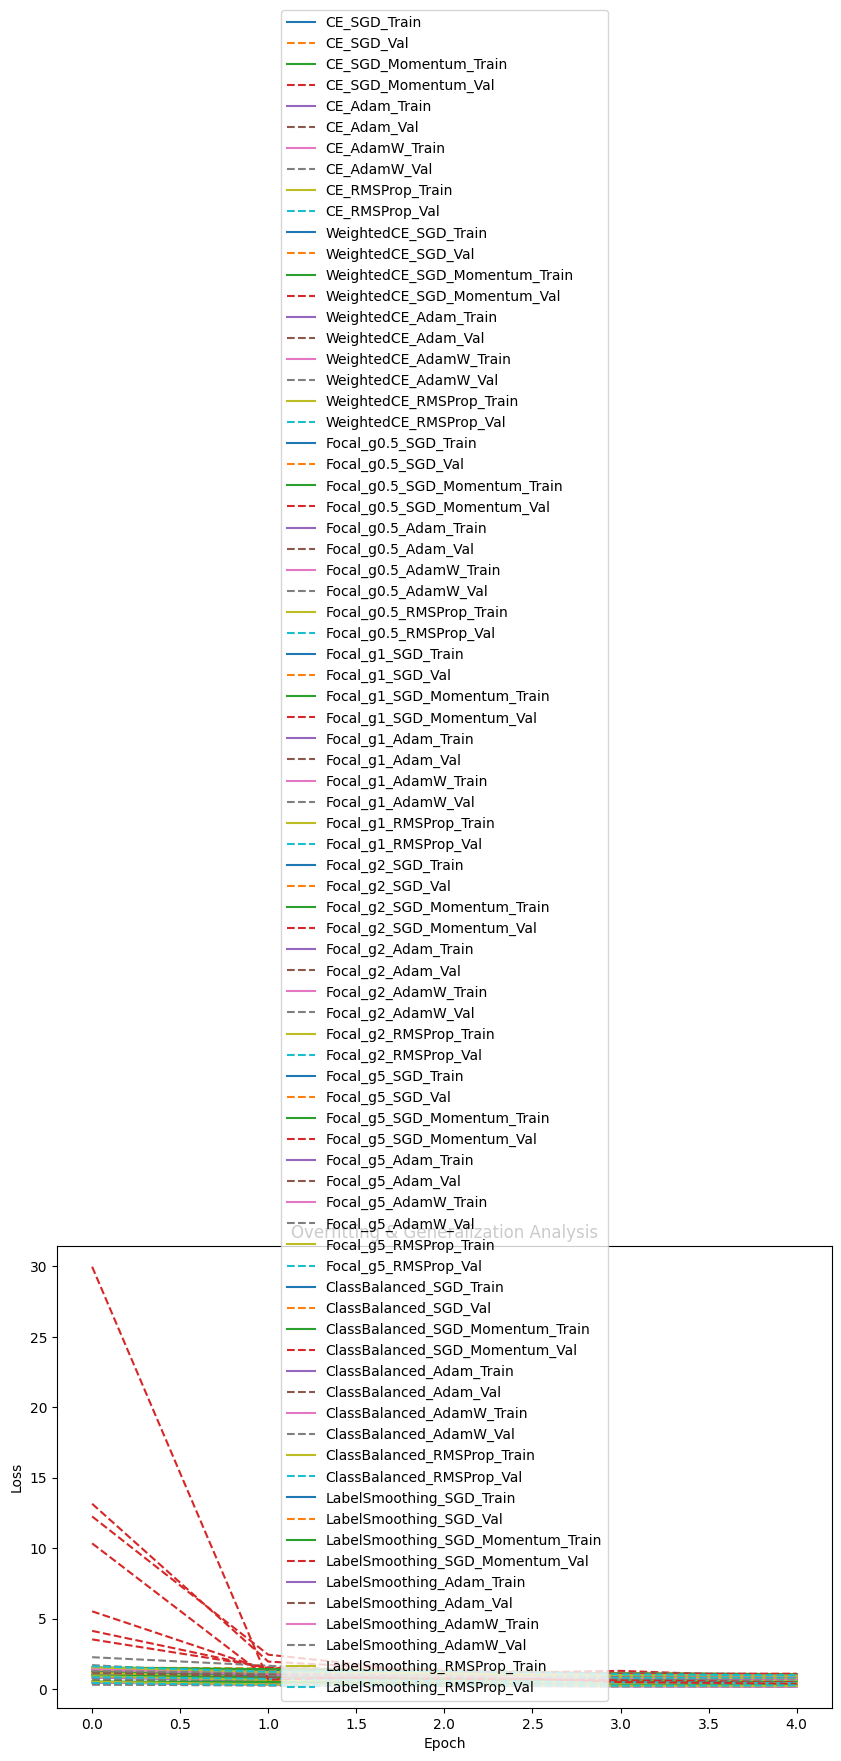

In [14]:
plt.figure(figsize=(10,6))

for name in results:
    plt.plot(results[name]["train"], label=f"{name}_Train")
    plt.plot(results[name]["val"], linestyle='--', label=f"{name}_Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Overfitting & Generalization Analysis")
plt.legend()
plt.show()


In [15]:
from sklearn.metrics import classification_report

for name in results:
    model = results[name]["model"]
    model.eval()

    preds, labels = [], []

    with torch.no_grad():
        for images, target in flower_val_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            preds.extend(predicted.cpu().numpy())
            labels.extend(target.numpy())

    report = classification_report(labels, preds, output_dict=True)

    print(name,
          "Minority F1:",
          report[str(minority_class)]["f1-score"])


CE_SGD Minority F1: 0.8045112781954887
CE_SGD_Momentum Minority F1: 0.7428571428571429
CE_Adam Minority F1: 0.8306451612903226
CE_AdamW Minority F1: 0.8
CE_RMSProp Minority F1: 0.7662835249042146
WeightedCE_SGD Minority F1: 0.7560137457044673
WeightedCE_SGD_Momentum Minority F1: 0.7579617834394905
WeightedCE_Adam Minority F1: 0.8052805280528053
WeightedCE_AdamW Minority F1: 0.7732342007434945
WeightedCE_RMSProp Minority F1: 0.7959866220735786
Focal_g0.5_SGD Minority F1: 0.7896678966789668


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Focal_g0.5_SGD_Momentum Minority F1: 0.0
Focal_g0.5_Adam Minority F1: 0.8175675675675675
Focal_g0.5_AdamW Minority F1: 0.7786259541984732


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Focal_g0.5_RMSProp Minority F1: 0.0
Focal_g1_SGD Minority F1: 0.7596899224806202
Focal_g1_SGD_Momentum Minority F1: 0.717607973421927
Focal_g1_Adam Minority F1: 0.7457627118644068
Focal_g1_AdamW Minority F1: 0.7747035573122529
Focal_g1_RMSProp Minority F1: 0.710801393728223
Focal_g2_SGD Minority F1: 0.7253521126760564
Focal_g2_SGD_Momentum Minority F1: 0.8042704626334519
Focal_g2_Adam Minority F1: 0.7630522088353414
Focal_g2_AdamW Minority F1: 0.8333333333333334
Focal_g2_RMSProp Minority F1: 0.7250996015936255
Focal_g5_SGD Minority F1: 0.6666666666666666
Focal_g5_SGD_Momentum Minority F1: 0.6883116883116883
Focal_g5_Adam Minority F1: 0.7194719471947195
Focal_g5_AdamW Minority F1: 0.779783393501805
Focal_g5_RMSProp Minority F1: 0.6626506024096386
ClassBalanced_SGD Minority F1: 0.7626459143968871
ClassBalanced_SGD_Momentum Minority F1: 0.825938566552901
ClassBalanced_Adam Minority F1: 0.8156028368794326
ClassBalanced_AdamW Minority F1: 0.8297872340425532
ClassBalanced_RMSProp Minority F1

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/5] Train Loss: 1.3396 | Val Loss: 1.2298
Epoch [2/5] Train Loss: 1.0752 | Val Loss: 0.9313
Epoch [3/5] Train Loss: 0.9619 | Val Loss: 0.9960
Epoch [4/5] Train Loss: 0.8750 | Val Loss: 0.8693
Epoch [5/5] Train Loss: 0.7993 | Val Loss: 0.8582
Epoch [1/5] Train Loss: 1.3448 | Val Loss: 1.0450
Epoch [2/5] Train Loss: 1.0846 | Val Loss: 0.9722
Epoch [3/5] Train Loss: 0.9393 | Val Loss: 0.9395
Epoch [4/5] Train Loss: 0.7901 | Val Loss: 0.7658
Epoch [5/5] Train Loss: 0.7141 | Val Loss: 0.7086


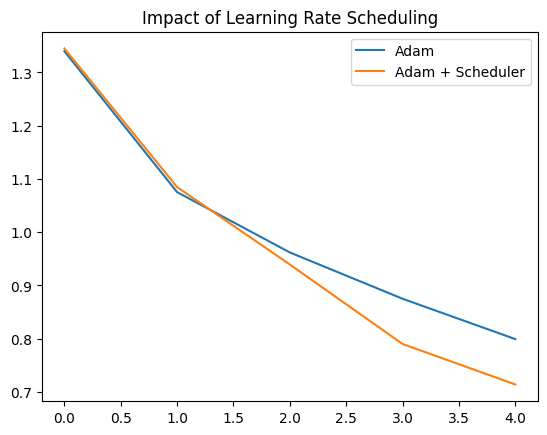

In [16]:
# Adam without scheduler
model_no_sched = get_efficientnet(num_classes).to(device)
optimizer = optim.Adam(model_no_sched.parameters(), lr=0.001)

train_no_sched, _ = train_model(
    model_no_sched,
    flower_train_loader,
    flower_val_loader,
    ce_loss,
    optimizer,
    scheduler=None,
    epochs=5
)

# Adam with scheduler
model_sched = get_efficientnet(num_classes).to(device)
optimizer = optim.Adam(model_sched.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

train_sched, _ = train_model(
    model_sched,
    flower_train_loader,
    flower_val_loader,
    ce_loss,
    optimizer,
    scheduler=scheduler,
    epochs=5
)

plt.plot(train_no_sched, label="Adam")
plt.plot(train_sched, label="Adam + Scheduler")
plt.legend()
plt.title("Impact of Learning Rate Scheduling")
plt.show()
